In [292]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import hdbscan
import socket
import struct

In [293]:
DS1 = "csv/convert/capture1_1.csv"
DSMERGED = "csv/convert/capture_merge_1.csv"
LOG = "csv/conn.log.labeled"

# Datensatzauswahl

Welche Datensätze haben wir in betracht gezogen und warum haben wir uns für diesen entschieden?

# Vorstellung der .log files und deren Struktur 
### Beispielhaft für Datensatz 1

In [11]:
fields=["ts","uid","orig_h","orig_p","resp_h","resp_p","proto","service","duration","orig_bytes","resp_bytes","conn_state","local_orig","local_resp","missed_bytes","history","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes","tunnel_parents","label","detailed-label"]

df_raw_log = pd.read_csv(LOG,skipfooter=1, engine="python", names=fields, sep="\x09|\x20\x20\x20", skiprows=8)
df_raw_log = df_raw_log.replace('-', np.nan)


In [12]:
pd.set_option('display.max_columns', None)
df_raw_log.head()

,ts,uid,orig_h,orig_p,resp_h,resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,NaN,2.999051,0,0,S0,NaN,NaN,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,NaN,2.998796,0,0,S0,NaN,NaN,0,S,3,180,0,0,(empty),Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,NaN,NaN,NaN,NaN,S0,NaN,NaN,0,S,1,60,0,0,(empty),Malicious,PartOfAHorizontalPortScan


### Spaltenübersicht

<div style="tposition>
    
| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |
</div>

In [13]:
df_raw_log.columns

Index(['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service',
       'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig',
       'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes',
       'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label',
       'detailed-label'],
      dtype='object')

In [14]:
df_raw_log.isna().sum()

ts                      0
uid                     0
orig_h                  0
orig_p                  0
resp_h                  0
resp_p                  0
proto                   0
service           1005507
duration           796300
orig_bytes         796300
resp_bytes         796300
conn_state              0
local_orig        1008748
local_resp        1008748
missed_bytes            0
history             17421
orig_pkts               0
orig_ip_bytes           0
resp_pkts               0
resp_ip_bytes           0
tunnel_parents          0
label                   0
detailed-label     469275
dtype: int64

| Spalte Original   | Beschreibung                      | behalten  | 
|-------------------|-----------------------------------|-----------|
| ts		        | Zeitstempel 			            | X         |
| uid		        | UUID 			                    | X         |
| orig_h		    | IP sender adresse  			    | X         |
| orig_p		    | Sender port 			            | X         |
| resp_h		    | IP Empfänger addresse 			| X         |
| resp_p		    | Empfänger port 			        | X         |
| proto		        | Protokoll 			            | X         |
| service		    | Dienst 			                | X         |
| duration		    | Dauer 			                | X         |
| orig_bytes		| Ursprüngliche Bytes 		        | X         |
| resp_bytes		| Antwortbytes 			            | X         |
| conn_state		| Verbindungszustand 		        | X         |
| local_orig		| Lokal (Ursprung) 		            | X         |
| local_resp		| Lokal (Antwort) 		            | X         |
| missed_bytes	    | Verpasste Bytes 		            | X         |
| history		    | Historie 			                | X         |
| orig_pkts		    | Ursprüngliche Pakete 		        | X         |
| orig_ip_bytes	    | Ursprüngliche IP-Bytes 	        | X         |
| resp_pkts		    | Antwortpakete 			        | X         |
| resp_ip_bytes	    | Antwort IP-Bytes 		            | X         |
| tunnel_parents	| Tunnel-Eltern 			        | X         |
| label		        | Gut oder Schlecht 		        | X         |
| detailed-label	| Angriffsmethode 		            | X         |


## Encoding der Spalten

In [294]:
protos = list(df_raw_log.proto.unique().flatten())
conn_states = list(df_raw_log.conn_state.unique().flatten())
histories = list(df_raw_log.history.unique().flatten())
def convert_ipv4(addr):
    """Konvertieren einer IPv4 Adresse zu einem INT"""
    return struct.unpack("!I", socket.inet_aton(addr))[0]

def con_proto(proto):
    """Konvertieren der Ports ICMP, TCP und UDP zu einem INT"""
    return protos.index(proto)

def convert_connstate(state):
    return conn_states.index(state)

def convert_histories(history):
    return histories.index(history)
        

### Konvertieren des DataFrames in ein normiertes Format
1. Konvertieren der IPv4 Spalten
2. Konvertieren der Protokoll Spalte
3. Löschen der ts und uid spalten

In [295]:
def norm_df(df):
    """
    Normierung des DataFrames, dh löschen der Spalten, welche nicht gebraucht werden und konvertieren der object Spalten zu INT
    """
    df = df.replace('-', np.nan)
    df['orig_h'] = df['orig_h'].apply(convert_ipv4)
    df['resp_h'] = df['resp_h'].apply(convert_ipv4)
    df['proto'] = df['proto'].apply(con_proto)
    df['conn_state'] = df['conn_state'].apply(convert_connstate)
    df['history'] = df['history'].apply(convert_histories)
    df = df.drop(['uid', 'ts', 'tunnel_parents', 'detailed-label', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp'], axis=1)
    df['label'] = (df['label'] == "Malicious").astype(int)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

In [296]:
df_conversion_1 = norm_df(df_raw_log)

In [297]:
df_conversion_1.dtypes

orig_h           int64
orig_p           int64
resp_h           int64
resp_p           int64
proto            int64
conn_state       int64
missed_bytes     int64
history          int64
orig_pkts        int64
orig_ip_bytes    int64
resp_pkts        int64
resp_ip_bytes    int64
label            int64
dtype: object

In [298]:
df_conversion_1.head(20)

,orig_h,orig_p,resp_h,resp_p,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,3232261223,51524,1098901923,23,0,0,0,0,3,180,0,0,1
1,3232261223,56305,1066799275,23,0,0,0,0,1,60,0,0,1
2,3232261223,41101,1864898353,23,0,0,0,0,1,60,0,0,1
3,3232261223,60905,2209273747,23,0,0,0,0,3,180,0,0,1
4,3232261223,44301,1529491263,23,0,0,0,0,1,60,0,0,1
5,3232261223,50244,2027056328,23,0,0,0,0,1,60,0,0,1
6,3232261223,34243,2466726347,49560,0,0,0,0,3,180,0,0,0
7,3232261223,34840,2443453190,21288,0,0,0,0,1,60,0,0,0
8,3232261223,58525,2974521213,23,0,0,0,0,1,60,0,0,1
9,3232261223,43849,1586579063,8080,0,0,0,0,1,60,0,0,1


In [299]:
df_conversion_1.label.value_counts()

label
1    539473
0    469275
Name: count, dtype: int64

In [21]:
def viz(df):
    for c, label in enumerate(df.columns):
        counts, edges, bars = plt.hist(df[df["label"] == 1][label], color='blue', label='Malicious', alpha=0.7, density=True, stacked=True)
        counts2, edges2, bars2 = plt.hist(df[df["label"] ==  0][label], color='red', label='Benign', alpha=0.7, density=True, stacked=True)
        plt.title(label)
        plt.ylabel("probability density")
        plt.xlabel(label)
        plt.legend()
        plt.show()

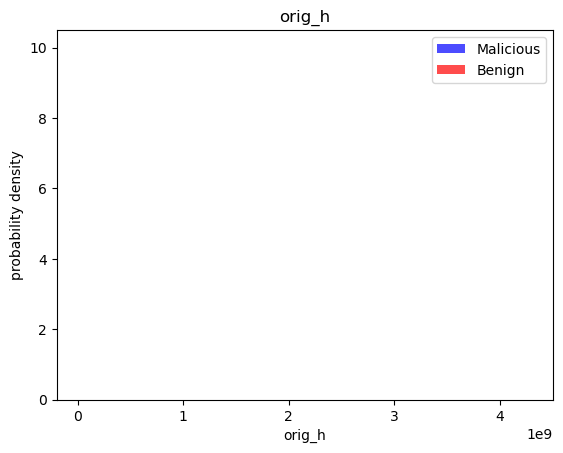

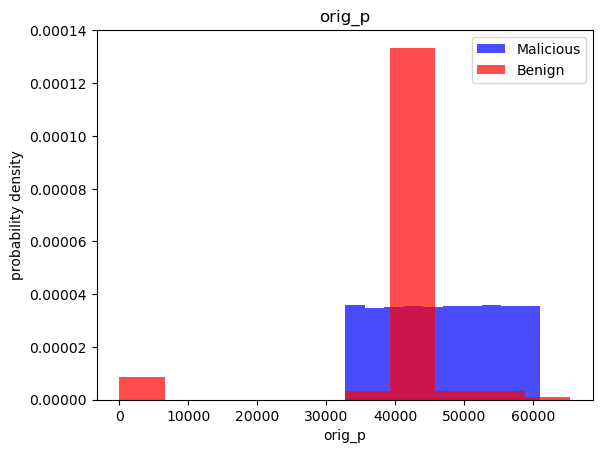

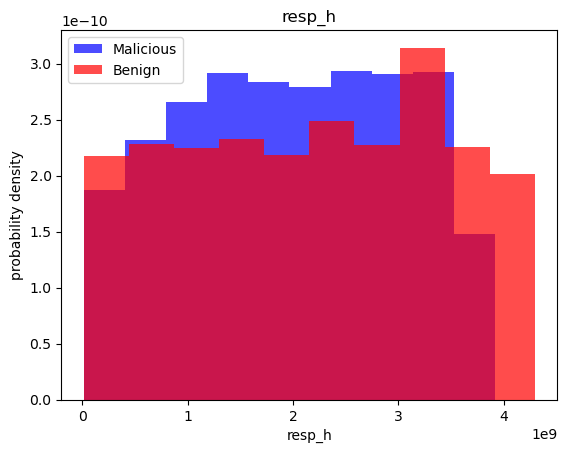

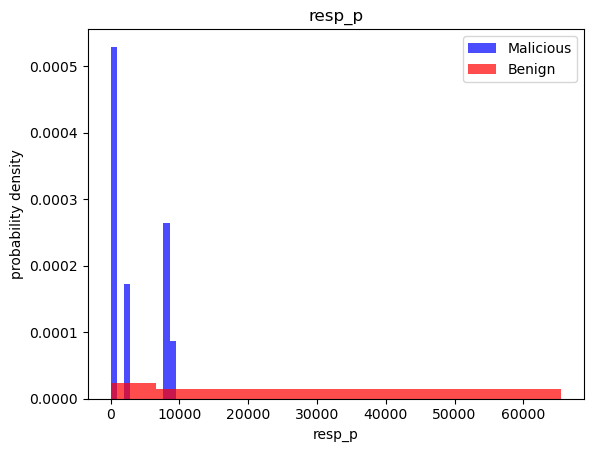

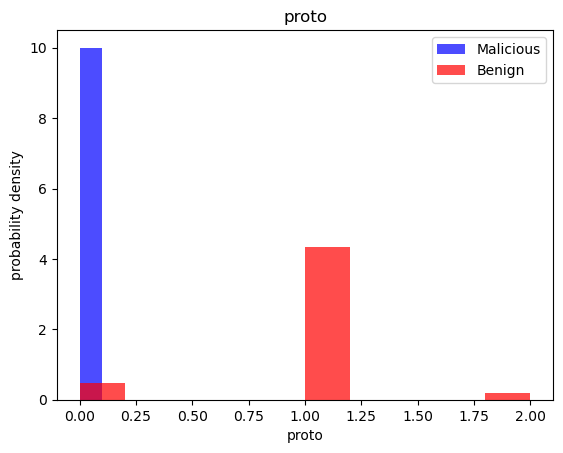

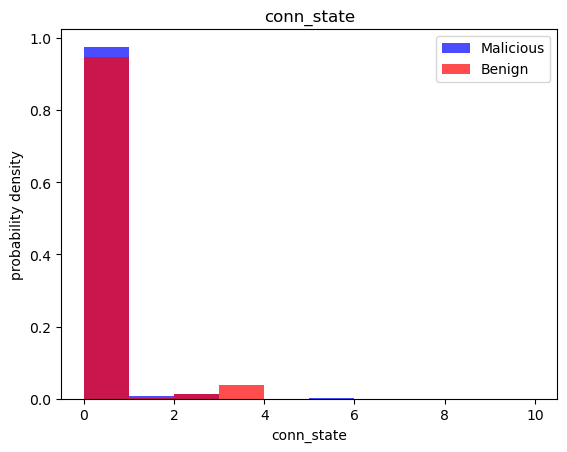

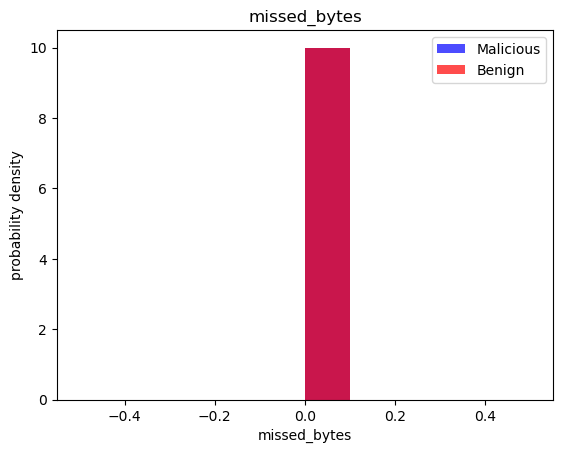

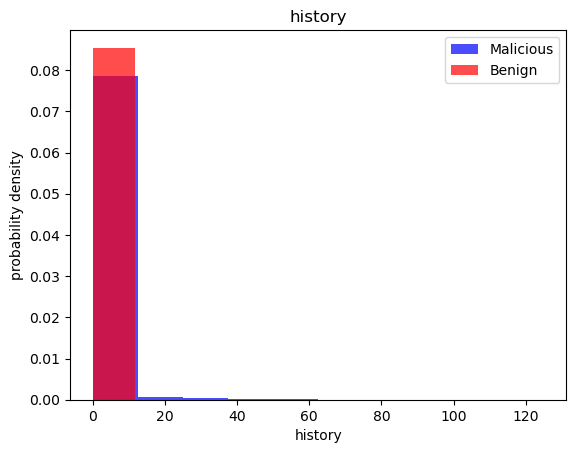

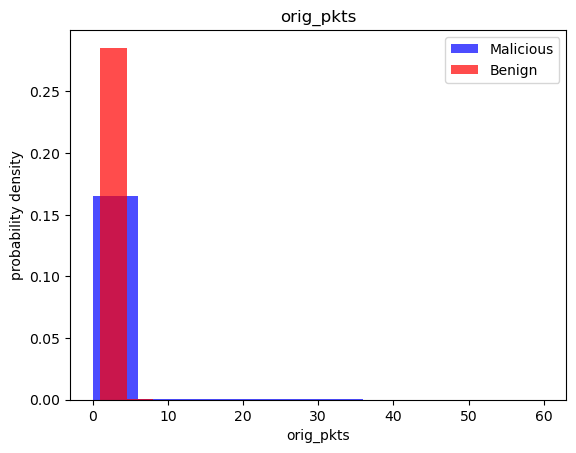

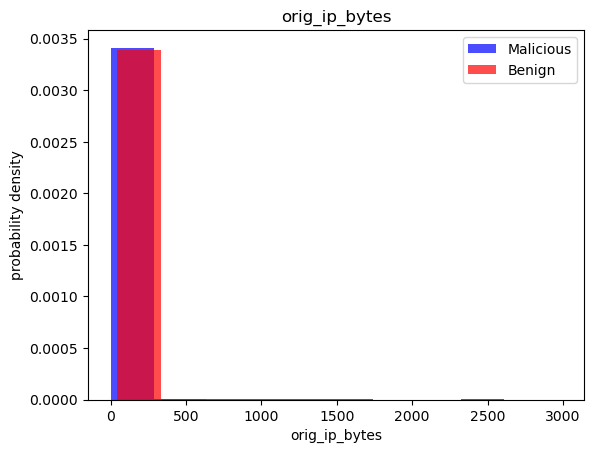

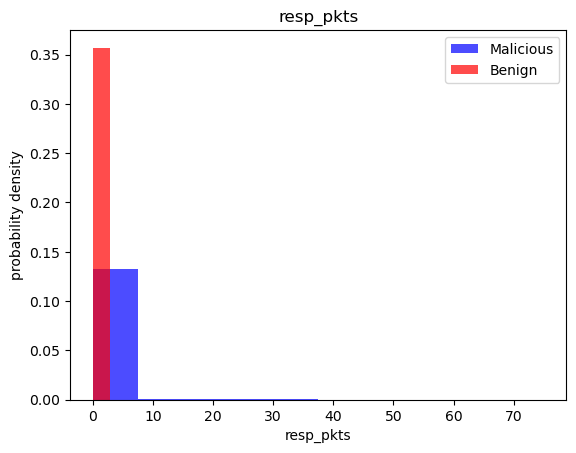

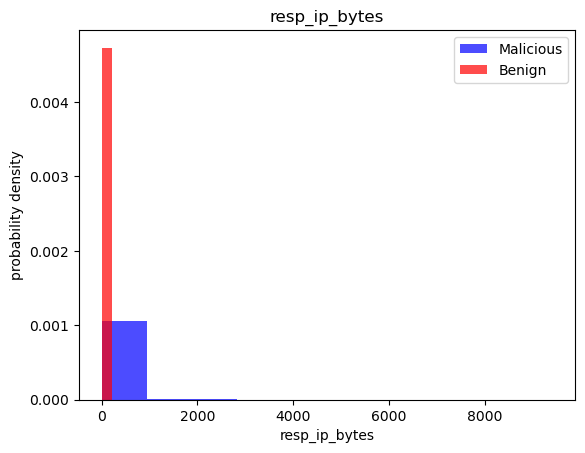

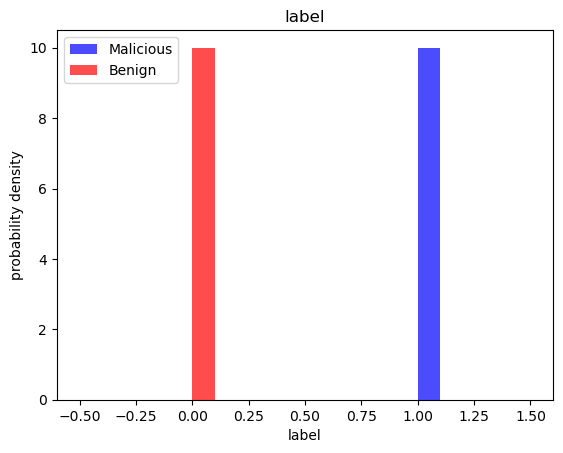

In [22]:
viz(df_conversion_1)

## Scatter plot der Daten

In [23]:
def make_bytes_plot(df) -> plt.figure:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='label', ax=ax1)
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue='proto', ax=ax3)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='label', ax=ax2)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue='proto', ax=ax4)
    plt.show()
    return fig

In [ ]:
make_bytes_plot(df_conversion_1)

# Konvertierung eines .log files in eine CSV

In [276]:
df_ds1 = pd.read_csv(DS1)
df_ds1 = df_ds1.drop(['Unnamed: 0'], axis=1)
df_dsmerged = pd.read_csv(DSMERGED)
df_dsmerged = df_dsmerged.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [26]:
df_ds1

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,59686,1159721954,8080,1,1
1,3232261223,43763,3663581508,47061,2,0
2,3232261223,51353,2712346730,2323,1,1
3,3232261223,43763,2028023405,39377,2,0
4,3232261223,45543,987512794,23,1,1
...,...,...,...,...,...,...
1008740,3232261223,44552,873217422,2323,1,1
1008741,3232261223,52111,3145280628,23,1,1
1008742,3232261223,56553,593749694,2323,1,1
1008743,3232261223,48087,716058614,8080,1,1


In [27]:
df_dsmerged

,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,43763,3663581508,47061,2,0
1,3232261223,43763,2028023405,39377,2,0
2,3232261223,43763,2713856255,20457,2,0
3,3232261223,43763,1066870262,16504,2,0
4,3232261223,43763,3798348164,37327,2,0
...,...,...,...,...,...,...
2123247,3232235972,3372,908547944,992,1,1
2123248,3232235972,30751,3512843912,80,1,1
2123249,3232235972,16764,908547944,992,1,1
2123250,3232235972,4020,3512843912,80,1,1


---

# Klassifizierung der Daten mit DBSCAN und HDBSCAN

## Beispielhaft für Datensatz 1

In [91]:
def dbscanner(df, title):
    dbscan = DBSCAN(eps=8, min_samples=4).fit(df)
    labels=dbscan.labels_
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue=labels, ax=ax1)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue=labels, ax=ax2)
    plt.title(title)
    plt.show()

In [98]:
def hdbscanner(df, title):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.scatterplot(data=df, x='orig_p', y='resp_p', hue=labels, ax=ax1)
    sns.scatterplot(data=df, x='orig_ip_bytes', y='resp_ip_bytes', hue=labels, ax=ax2)
    plt.title(title)
    plt.show()

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


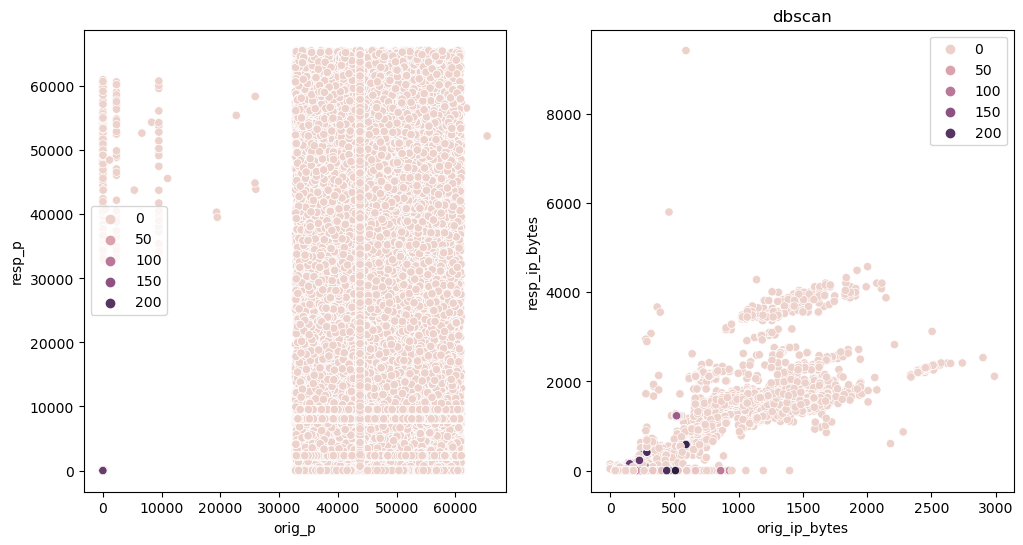

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


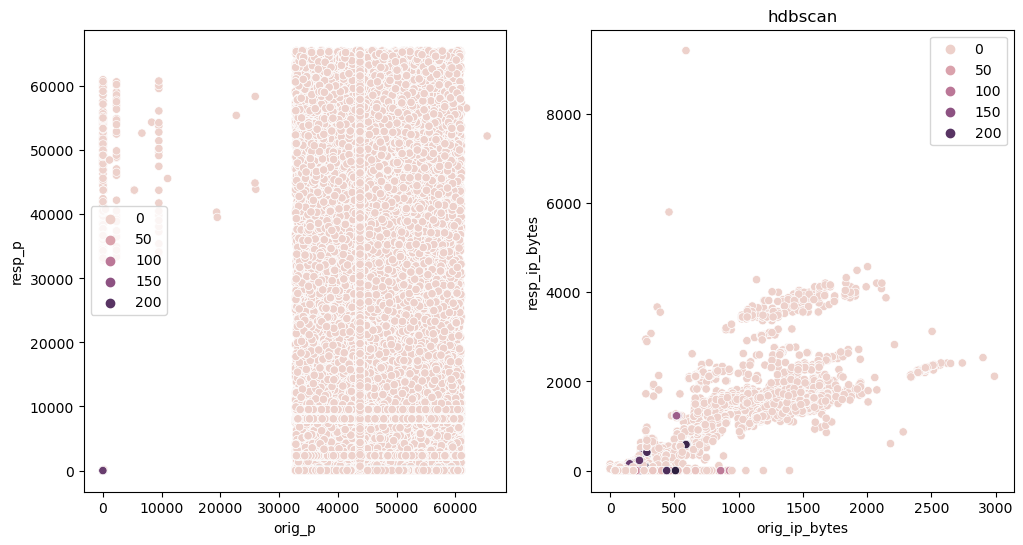

In [99]:
dbscanner(df_conversion_1, "dbscan")
dbscanner(df_conversion_1, "hdbscan")

---

# Mergen der dateien 1, 7, 35

In [253]:
def merge(datasets: list):
  df_return = pd.DataFrame()
  for d in datasets:
    df = pd.read_csv(f"work/csv/convert/capture{d}_1.csv")
    print(f"====\nDF{d}")
    print(f"shape before: {df.shape}")
    print(f"labels before:\n\t1:: {len(df[df['label'] == 1])}\n\t0:: {len(df[df['label'] == 0])}")
    l_dfs = [df[df['label'] == 0], df[df['label'] == 1]]
    for label in [0,1]:
      if len(l_dfs[label]) > 500_000:
        percent = 500_000 / len(l_dfs[label])
        print(f"cut {1-percent} off label == {label}")
        l_dfs[label] = np.array_split(l_dfs[label].sample(frac=1), 1/percent)[0]
    df = pd.concat(l_dfs, ignore_index=1)
    df_return = pd.DataFrame(pd.concat([df_return,df],ignore_index = True))
  print("=== now changing the df_return ===")
  ones = len(df_return[df_return['label'] == 1])
  zeros = len(df_return[df_return['label'] == 0])
  thebigger = 1 if ones > zeros else 0
  perc = zeros / ones
  print("shape before: ")
  print(df_return["label"].value_counts())
  print(f"ratio: {perc}")
  perc =  1 - perc if perc > 1 else perc
  print(f"cut_perc {perc}")
  l_dfs = [df_return[df_return['label'] == 0], df_return[df_return['label'] == 1]]
  rows_to_cut = int(len(l_dfs[thebigger]) * perc)
  l_dfs[thebigger] = l_dfs[thebigger].iloc[:rows_to_cut]
  df_return = pd.concat(l_dfs)
  print("===\nshape after: ")
  print(df_return["label"].value_counts())
  print(f"shape: {df_return.shape}")
  return df_return

In [136]:
ids = [1,7,35]
df = merge(ids)

FileNotFoundError: [Errno 2] No such file or directory: 'work/csv/convert/capture1_1.csv'

---

# Training der Datensätze

## Split in Test-, Validierung- und Trainingsdatensatz, Oversampling

In [300]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler

In [301]:
def split(df):
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train, valid, test

In [302]:
X = pd.DataFrame()
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [323]:
train, valid, test = split(df_dsmerged) # Hier umstellen df_ds1 oder df_dsmerged
train, X_train, y_train = scale(train, True) 
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 

## Datensatz 1

### kNN

In [272]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#### kNN - K-Optimierung


In [273]:
k_range=range(1,10)
knn_r_acc = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', weights='distance', metric='euclidean')
    knn.fit(X_train,y_train)

    train_score = knn.score(X_train,y_train)
    test_score = knn.score(X_test,y_test)
    vaild_score = knn.score(X_valid,y_valid)

    knn_r_acc.append((k, train_score,test_score, vaild_score))

    print(f"finished {k}")

df = pd.DataFrame(knn_r_acc, columns=['K','Train Score', 'Test Score','Vaild Score'])
print(df)

finished 1
finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
   K  Train Score  Test Score  Vaild Score
0  1          1.0    0.998592     0.998657
1  2          1.0    0.998592     0.998657
2  3          1.0    0.998131     0.998414
3  4          1.0    0.997928     0.998151
4  5          1.0    0.997626     0.997963
5  6          1.0    0.997358     0.997784
6  7          1.0    0.997026     0.997626
7  8          1.0    0.996823     0.997373
8  9          1.0    0.996634     0.997105


#### kNN - Endergebnis

In [274]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree',  weights='distance', metric='euclidean')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94078
           1       1.00      1.00      1.00    107671

    accuracy                           1.00    201749
   macro avg       1.00      1.00      1.00    201749
weighted avg       1.00      1.00      1.00    201749



### dTrees

In [ ]:
# Imports
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
# capture1_1.csv
train, valid, test = split(df_ds1)
train, X_train, y_train = scale(train, True)
valid, X_valid, y_valid = scale(valid, False)
test, X_test, y_test = scale(test, False)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
# Note: with ccp_alpha you can prune the tree if it is overfitting the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree = DecisionTreeClassifier(ccp_alpha=0.1, max_depth=4, random_state=1)

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

dtree.get_params()

### ANN

In [ ]:
@Jonny

## Zusammengesetzer Datensatz (merged) 

### kNN

In [278]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [279]:
X = df_dsmerged.drop('label',axis=1)
y = df_dsmerged.label

#### Hyperparameter Optimierung n_neighbors kNN

In [280]:
from sklearn.model_selection import GridSearchCV

grid_params = {
'n_neighbors': [1,2,3,4,5,6],
'weights': ['uniform', 'distance'],
'metric': ['euclidean', 'manhattan'],
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 10,
    cv = 3,     # Determines the cross-validation splitting strategy
                # integer, to specify the number of folds
    #n_jobs = -1 # use all processors to perform the model
)

gs_results = gs.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START metric=euclidean, n_neighbors=1, weights=uniform...........
[CV 1/3; 1/24] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.797 total time=  37.4s
[CV 2/3; 1/24] START metric=euclidean, n_neighbors=1, weights=uniform...........
[CV 2/3; 1/24] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.908 total time=  33.4s
[CV 3/3; 1/24] START metric=euclidean, n_neighbors=1, weights=uniform...........
[CV 3/3; 1/24] END metric=euclidean, n_neighbors=1, weights=uniform;, score=0.964 total time=  33.8s
[CV 1/3; 2/24] START metric=euclidean, n_neighbors=1, weights=distance..........
[CV 1/3; 2/24] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.797 total time=  14.1s
[CV 2/3; 2/24] START metric=euclidean, n_neighbors=1, weights=distance..........
[CV 2/3; 2/24] END metric=euclidean, n_neighbors=1, weights=distance;, score=0.908 total time=  10.1s
[CV 3/3; 2/24] START metric

In [281]:
gs_results.best_score_

0.8986799842095562

In [282]:
gs_results.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [283]:
gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

#### kNN - Plot Results

In [284]:
def plot_search_results(grid):
    """
    Params:
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

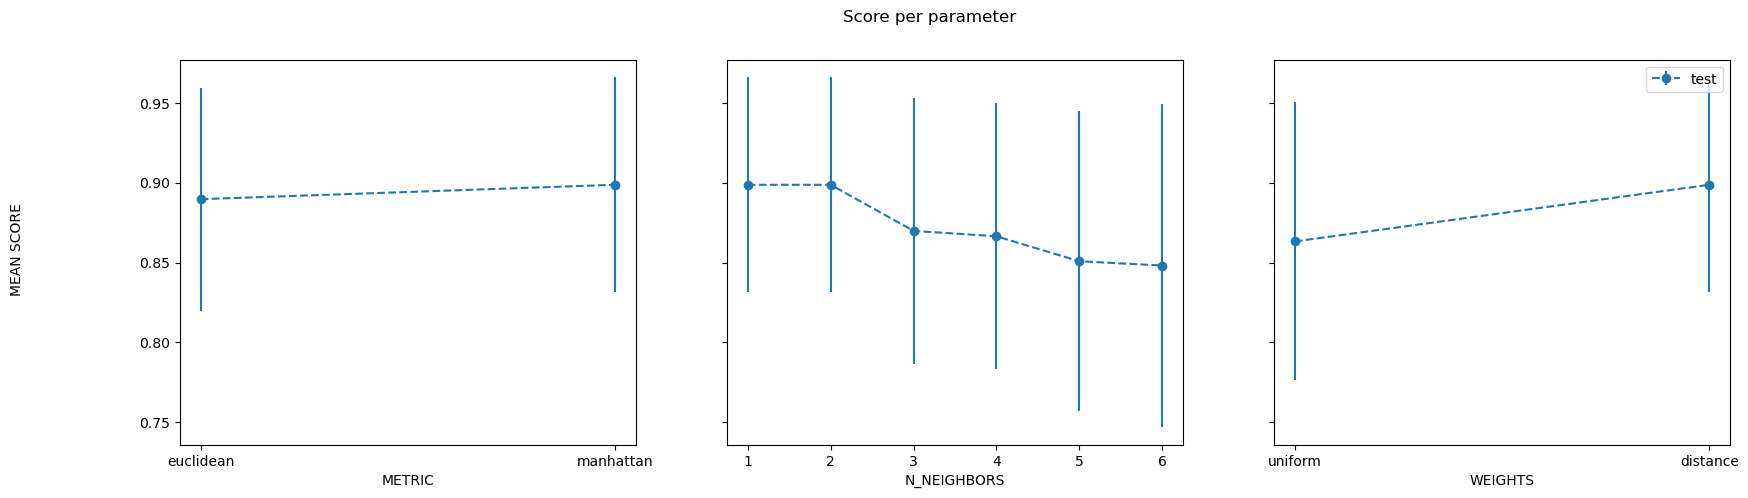

In [285]:
plot_search_results(gs_results)

#### kNN - Endergebnis

In [286]:
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan',weights='distance')
knn.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

In [287]:
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))
print(knn.score(X_valid,y_valid))

1.0
0.9150620156316599
0.9008595313787825


In [ ]:
y_pred = knn.predict(X_valid)
print(classification_report(y_valid, y_pred))

### DTrees

In [332]:
# capture_merge_1.csv
train, valid, test = split(df_dsmerged)
train, X_train, y_train = scale(train, True)
valid, X_valid, y_valid = scale(valid, False)
test, X_test, y_test = scale(test, False)

In [333]:
X_train

array([[ 0.06331016, -1.53900685, -0.93826618,  1.07688758, -0.48944156],
       [ 0.06331013,  1.34441107,  1.18898561, -0.37660893, -0.48944156],
       [ 0.06331013,  1.27720779, -1.35581109, -0.45256997, -0.48944156],
       ...,
       [ 0.06331013,  1.02725966, -0.223734  , -0.87552654, -0.48944156],
       [ 0.06331013,  1.09195457, -0.70936042, -0.87552654, -0.48944156],
       [ 0.06331013,  0.08970595,  0.36142316, -0.87552654, -0.48944156]])

In [334]:
df_ds1.columns
X_train[0]

array([ 0.06331016, -1.53900685, -0.93826618,  1.07688758, -0.48944156])

#### DTrees - Hyperparameter Tuning

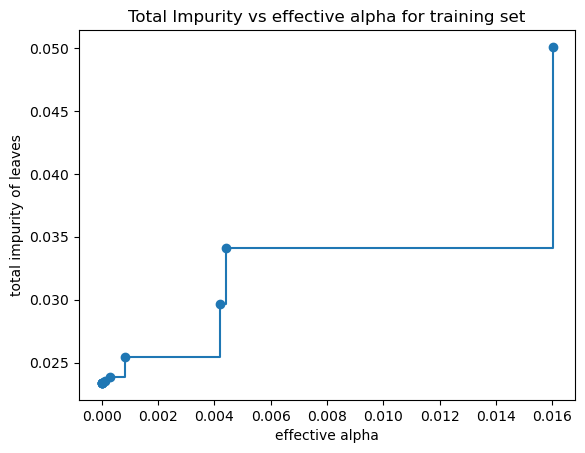

In [382]:
clf = DecisionTreeClassifier(max_depth=4,random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.savefig('img/effective_alpha.png')

In [385]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=4, random_state=1, criterion= "gini", ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.22495763022477686


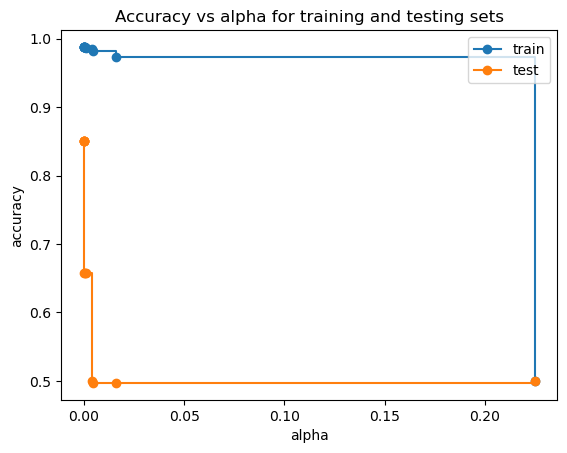

In [386]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.savefig('img/accuracy_alpha.png')

In [94]:
# GridSearchCV function
from sklearn.model_selection import GridSearchCV

def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = {'max_depth': [1,2,3,4],'random_state': [None,1,2], 'criterion': ['entropy', 'gini']}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds, n_jobs=30)
    #fit model to data
    dtree_gscv.fit(X, y)
    # print bets score achieved
    print(dtree_gscv.best_score_)

    return dtree_gscv.best_params_

In [95]:
X = df_ds1.copy()
y = X.label
X = X.drop(['label'], axis=1)

dtree_grid_search(X, y, 3)

0.9935989770664833


{'criterion': 'gini', 'max_depth': 4, 'random_state': None}

#### DTrees - Create and train tree

In [393]:
# Create Decision Tree classifer object
# Note: with ccp_alpha you can prune the tree if it is overfitting the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
dtree = DecisionTreeClassifier(ccp_alpha=0.1, max_depth=4, random_state=1)

# Train Decision Tree Classifer
dtree = dtree.fit(X_train,y_train)

dtree.get_params()

{'ccp_alpha': 0.1,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [394]:
# show difference between tree that doesn't have stopping criteria and the one that does
dtree.predict_proba(X_valid)

array([[0.99056731, 0.00943269],
       [0.04392955, 0.95607045],
       [0.99626998, 0.00373002],
       ...,
       [0.99626998, 0.00373002],
       [0.04392955, 0.95607045],
       [0.04392955, 0.95607045]])

In [395]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred)

0.9732933003650065

In [396]:
# Percision
from sklearn.metrics import precision_score
precision_score(y_valid, y_pred)

0.9548720454627719

In [397]:
# Recall from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
# true positives and false negatives
from sklearn.metrics import recall_score
recall_score(y_valid, y_pred)

0.9935643028308593

In [398]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.99      0.95      0.97    212241
   malicious       0.95      0.99      0.97    212409

    accuracy                           0.97    424650
   macro avg       0.97      0.97      0.97    424650
weighted avg       0.97      0.97      0.97    424650



#### DTrees - Feature importances

In [365]:
df_ds1_drop = df_ds1.drop(['label'], axis=1)
feature_names = df_ds1_drop.columns
feature_names

Index(['orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto'], dtype='object')

In [366]:
dtree.feature_importances_

array([0.36611892, 0.        , 0.        , 0.        , 0.63388108])

In [367]:
feature_importance = pd.DataFrame(dtree.feature_importances_, index = feature_names).sort_values(0, ascending=False)
feature_importance

,0
proto,0.633881
orig_h,0.366119
orig_p,0.000000
resp_h,0.000000
resp_p,0.000000


In [368]:
features = list(feature_importance[feature_importance[0]>0].index)
features

['proto', 'orig_h']

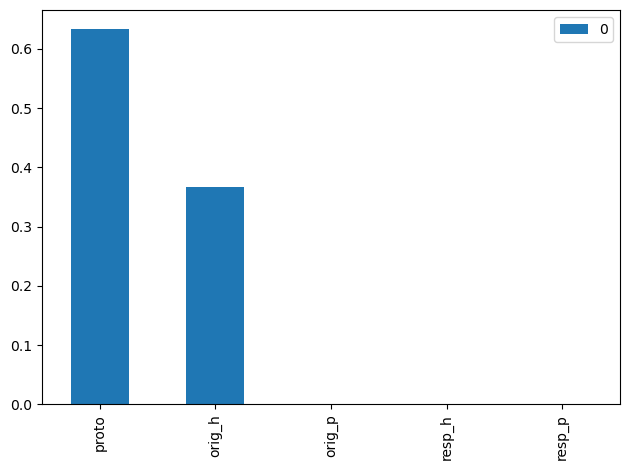

In [369]:
# feature plot
feature_importance.head(10).plot(kind='bar')
plt.tight_layout()
plt.savefig('img/feature.png')

#### DTrees - Tree plotting

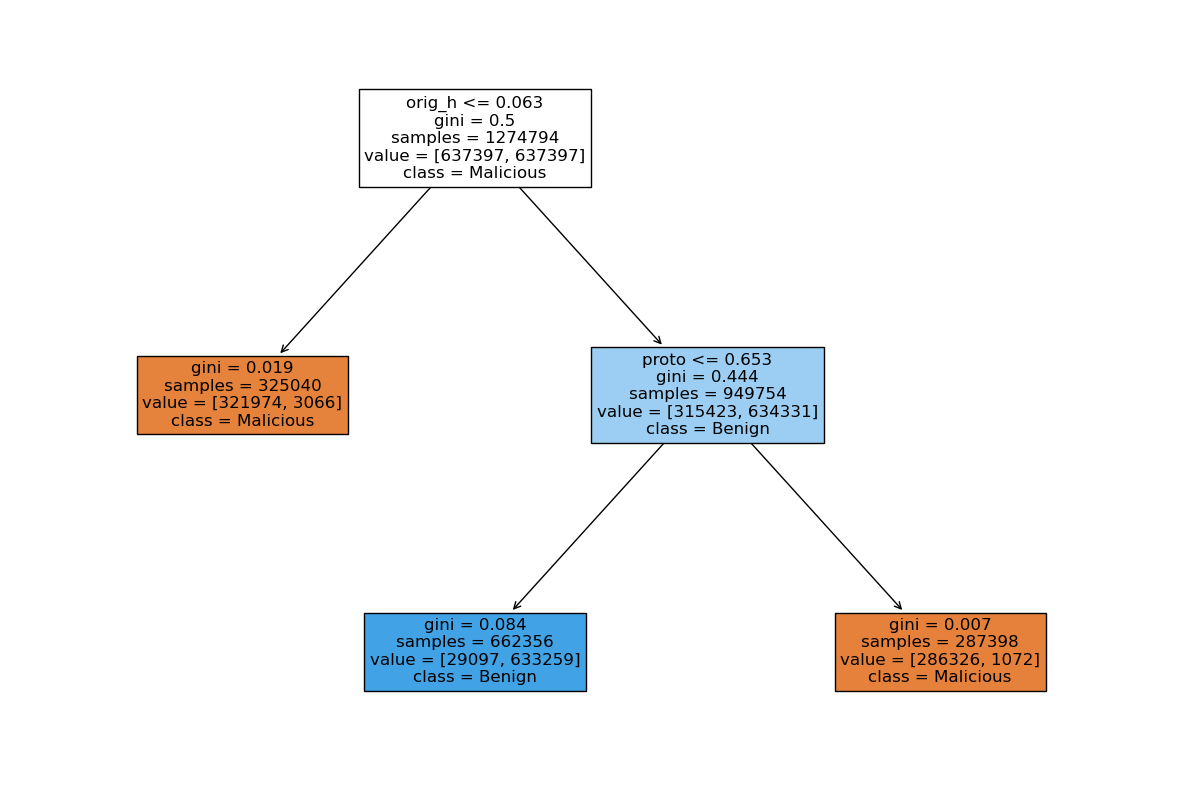

In [399]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(dtree, 
                   feature_names=feature_names,  
                   class_names={0:'Malicious', 1:'Benign'},
                   filled=True,
                  fontsize=12)
plt.savefig('img/dtree.png')

In [372]:
import joblib

filename = "dtree_merged.joblib"

# save model
joblib.dump(dtree, filename)

['dtree_merged.joblib']

In [291]:
# load model
loaded_model = joblib.load(filename)

# you can use loaded model to compute predictions
y_pred = loaded_model.predict(X_valid)
y_pred

accuracy_score(y_valid, y_pred)

0.8477828800188391

### ANN